In [10]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup


!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library


!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge geocoder --yes 
import geocoder
import os

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Lynn Mate\anaconda3

  added / updated specs:
    - geocoder


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geocoder-1.38.1            |             py_1          53 KB  conda-forge
    ratelim-0.1.6              |             py_2           6 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          59 KB

The following NEW packages will be INSTALLED:

  geocoder           conda-forge/noarch::geocoder-1.38.1-py_1
  ratelim            conda-forge/noarch::ratelim-0.1.6-py_2




ratelim-0.1.6        | 6 KB      |            |   0% 
ratelim-0.1.6

In [11]:
#define a function to get geocodes

In [12]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

#We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.


In [90]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=500
    CLIENT_ID = ['NFWN1KBWK43RLDNHNVNWYUXCRR4TZU4RRRIAOIQF3OUWBGGR'] # your Foursquare ID
    CLIENT_SECRET = ['31FX2Y3TSXPODRD1IS3HKV3TZXU5RLTZVWXKH4GHKLHLCBM1'] # your Foursquare Secret
    VERSION = '20200620' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]["groups"][0]["items"]
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [91]:
def get_venue_details(venue_id):
        
    CLIENT_ID = ['NFWN1KBWK43RLDNHNVNWYUXCRR4TZU4RRRIAOIQF3OUWBGGR'] # your Foursquare ID
    CLIENT_SECRET = ['31FX2Y3TSXPODRD1IS3HKV3TZXU5RLTZVWXKH4GHKLHLCBM1'] # your Foursquare Secret
    VERSION = '20200620' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [92]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [93]:
#call a function to get new york city data
new_york_data=get_new_york_data()

In [94]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [95]:
new_york_data.shape

(306, 4)

there arae 306 neighborhoods in new york

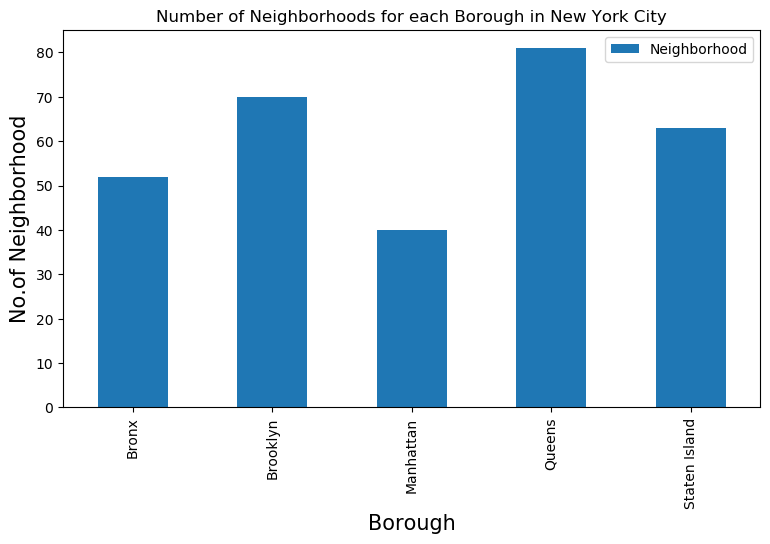

In [96]:
# create a bar plot for the neighborhoods

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhoods for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Queens has highest number of neighborhoods.

Let's find all the Italian Restaurants in New York

In [106]:

        
# prepare neighborhood list that contains italian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_restaurants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Italian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(italian_restaurants)))
    for restaurant_detail in italian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

    


KeyError: 'groups'

In [77]:
italian_rest_ny.head()

,Borough,Neighborhood,ID,Name


In [78]:
italian_rest_ny.shape

(0, 4)